In [4]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import scipy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.7.0
Model Maker Version: 0.3.4


In [5]:
# @title [Run this] Util functions and data structures.

data_dir = 'birds_dataset'

bird_code_to_name = {
    'Background Noise': 'Background Noise',
    'Brahminy Kite': 'Brahminy Kite',
    'Grey Parrot': 'Grey Parrot',
    'House Crow': 'House Crow',
    'Indian Eagle-Owl': 'Indian Eagle-Owl',
    'Indian Peafowl': 'Indian Peafowl',
    'Rock Dove': 'Rock Dove',
    'Silence': 'Silence'
}


test_files = os.path.join(data_dir, 'test\\*\\*.wav')

def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  print(random_audio_path)
  return random_audio_path

def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

def show_bird_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')
  sample_rate, audio_data = ensure_sample_rate(sample_rate, audio_data)

  bird_code = audio_path.split('\\')[-2]
  print(f'Bird name: {bird_code_to_name}')
  print(f'Bird code: {bird_code}')

  plttitle = f'{bird_code_to_name[bird_code]} ({bird_code})'
  plt.title(plttitle)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

birds_dataset\test\Indian Peafowl\XC677383 - Indian Peafowl - Pavo cristatus.wav
Bird name: {'Background Noise': 'Background Noise', 'Brahminy Kite': 'Brahminy Kite', 'Grey Parrot': 'Grey Parrot', 'House Crow': 'House Crow', 'Indian Eagle-Owl': 'Indian Eagle-Owl', 'Indian Peafowl': 'Indian Peafowl', 'Rock Dove': 'Rock Dove', 'Silence': 'Silence'}
Bird code: Indian Peafowl


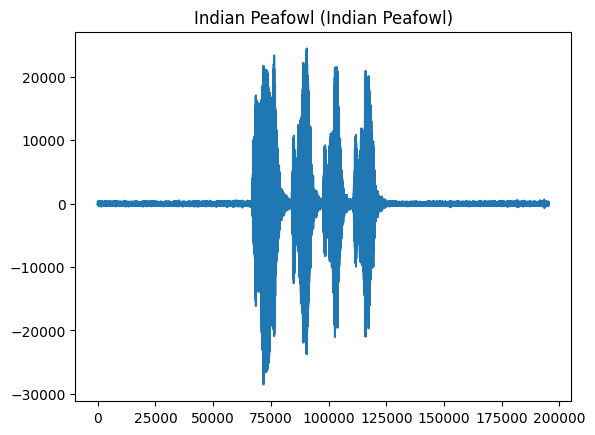

In [12]:
random_audio = get_random_audio_file()
show_bird_data(random_audio)

In [15]:
# spec = audio_classifier.YamNetSpec(
#     model_dir= "./checkpoints",
#     yamnet_model_handle='https://tfhub.dev/google/yamnet/1',
#     keep_yamnet_and_custom_heads= False,
#     frame_step= 1 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
#     frame_length= 3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

spec = audio_classifier.YamNetSpec(
    model_dir= "./checkpoints",
    yamnet_model_handle='https://tfhub.dev/google/yamnet/1',
    keep_yamnet_and_custom_heads= False)

INFO:tensorflow:Checkpoints are stored in ./checkpoints


INFO:tensorflow:Checkpoints are stored in ./checkpoints


In [16]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=False)
train_data, validation_data = train_data.split(0.75)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=False)

In [20]:
batch_size = 2
epochs = 10

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 8)                8200      
                                                                 
Total params: 8,200
Trainable params: 8,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2600/2600 [==============================] - 105s 39ms/step - loss: 0.7034 - acc: 0.8117 - val_loss: 1.6723 - val_acc: 0.5163
Epoch 2/10
2600/2600 [==============================] - 103s 39ms/step - loss: 1.0585 - acc: 0.8592 - val_loss: 1.7379 - val_acc: 0.5700
Epoch 3/10
2600/2600 [==============================] - 104s 39ms/step - loss: 0.7637 - acc: 0.8771 - val_loss: 1.7534 - val_acc: 0.5904
Epoch 4/10
2600/2600 [==============================] - 105s 39ms/step - loss: 0.5453 - acc: 0.8869 - val_loss: 1.8116 - val_acc: 0.6101
Epoch 5/10
26

In [21]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
29/29 [==============================] - 16s 389ms/step - loss: 1.8230 - acc: 0.8009


[1.822982907295227, 0.8008705377578735]

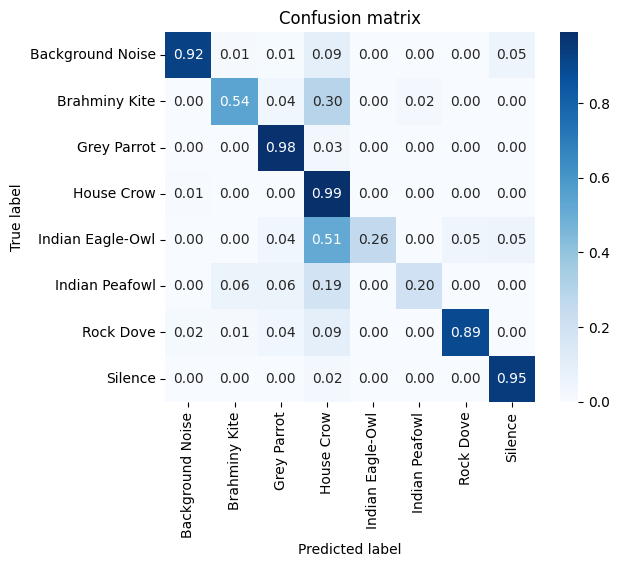

In [22]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [ ]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

In [ ]:
# if you want to try another file just uncoment the line below
random_audio = get_random_audio_file()
show_bird_data(random_audio)

In [ ]:
sample_rate, audio_data = wavfile.read(random_audio, 'rb')

audio_data = np.array(audio_data) / tf.int16.max
input_size = serving_model.input_shape[1]

splitted_audio_data = tf.signal.frame(audio_data, input_size, input_size, pad_end=True, pad_value=0)

print(f'Test audio path: {random_audio}')
print(f'Original size of the audio data: {len(audio_data)}')
print(f'Number of windows for inference: {len(splitted_audio_data)}')

In [ ]:
print(random_audio)

results = []
print('Result of the window ith:  your model class -> score,  (spec class -> score)')
for i, data in enumerate(splitted_audio_data):
  yamnet_output, inference = serving_model(data)
  results.append(inference[0].numpy())
  result_index = tf.argmax(inference[0])
  spec_result_index = tf.argmax(yamnet_output[0])
  t = spec._yamnet_labels()[spec_result_index]
  result_str = f'Result of the window {i}: ' \
  f'\t{test_data.index_to_label[result_index]} -> {inference[0][result_index].numpy():.3f}, ' \
  f'\t({spec._yamnet_labels()[spec_result_index]} -> {yamnet_output[0][spec_result_index]:.3f})'
  print(result_str)


results_np = np.array(results)
mean_results = results_np.mean(axis=0)
result_index = mean_results.argmax()
print(f'Mean result: {test_data.index_to_label[result_index]} -> {mean_results[result_index]}')

In [ ]:
models_path = './birds_models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='birds_model_v5_6-Species.tflite')